In [28]:
#Packages
import warnings
warnings.filterwarnings('ignore')

import glob
import csv

import numpy as np
from numpy import genfromtxt

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from PIL import Image

from pymks import (plot_microstructures, PrimitiveTransformer, TwoPointCorrelation)

plots_path = "./../../figures/statistics/"

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [9]:
#Append images to lists.
train_path = "./../../data/binarized/train/"
test_path = "./../../data/binarized/test/"

images_train = []
images_test = []

def number(filename):
    return filename[61:-4]

def number2(filename):
    return filename[60:-4]

for filename in sorted(glob.glob(train_path + "*.tif"), key=number):
    im=Image.open(filename)
    images_train.append(im)

for filename_b in sorted(glob.glob(test_path + "*.tif"), key=number2):
    im_b=Image.open(filename_b)
    images_test.append(im_b)

In [14]:
#List comprehensions to convert the members of the "images" lists to arrays.

imarrays_tr = [np.array(x) for x in images_train]
imarrays_te = [np.array(x1) for x1 in images_test]
#print(imarrays_te)

In [11]:
#Stacking all image arrays to create the 'sample' dimension and to convert the lists to arrays.

data_a_tr = np.stack(imarrays_tr, axis=0)
data_a_te = np.stack(imarrays_te, axis=0)
data_a_te.shape

(10, 600, 600)

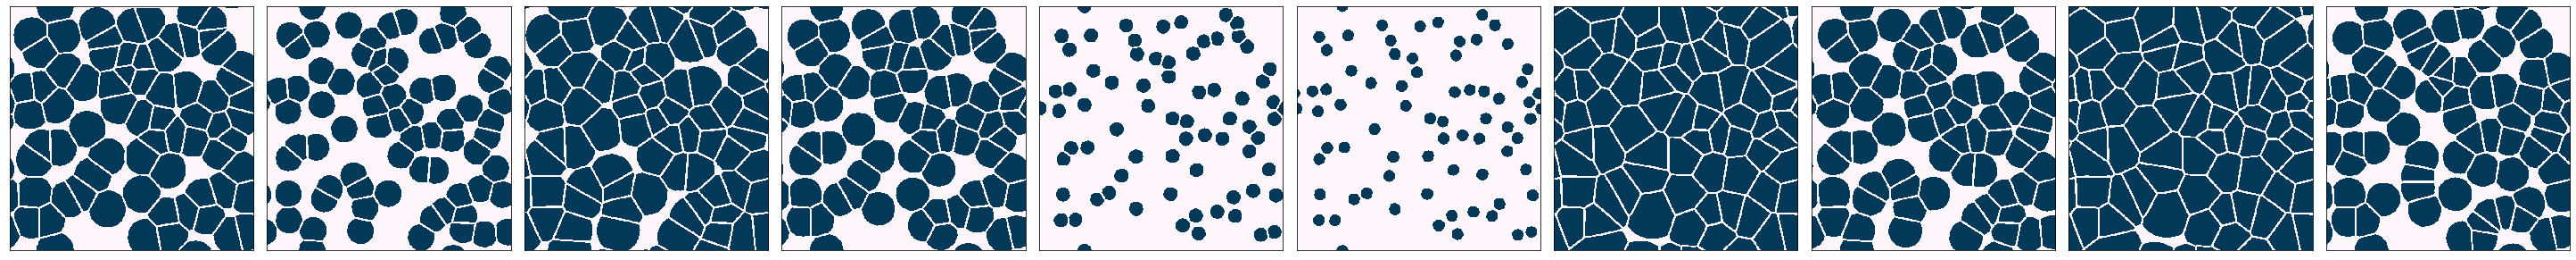

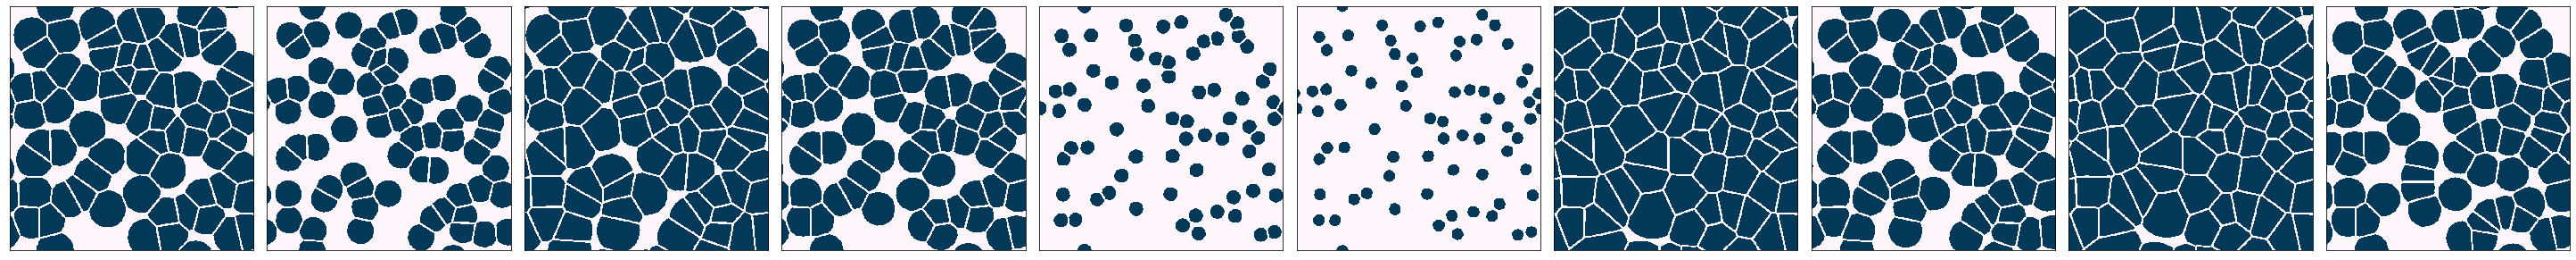

In [12]:
#Visualization of the first 10 training microstructures.

plot_microstructures(*data_a_tr[0:10], cmap='PuBu', colorbar=False)

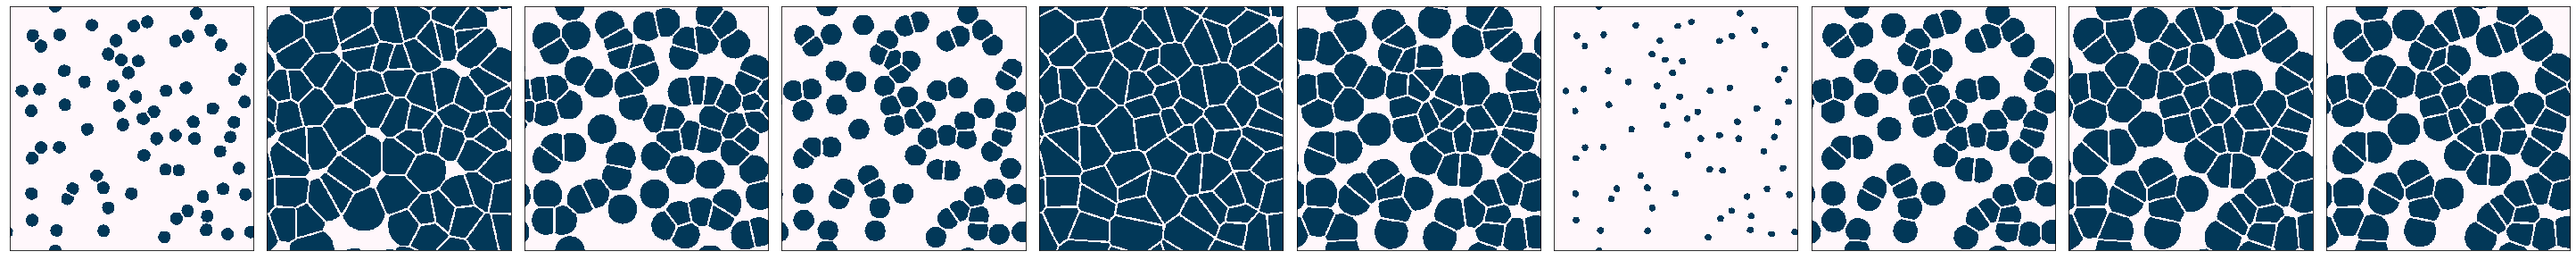

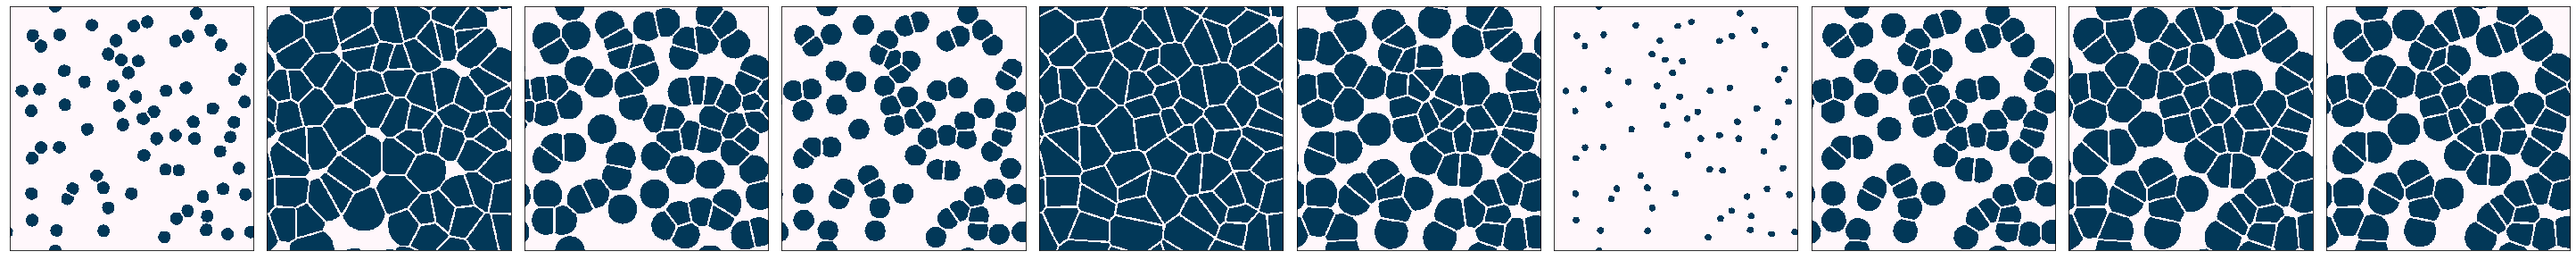

In [13]:
#Visualization of the testing microstructures.

plot_microstructures(*data_a_te[0:10], cmap='PuBu', colorbar=False)

In [15]:
#List comprehensions to add the "phases" axis with the PrimitiveTransformer class.

data_tr = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(data_a_tr)
data_te = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(data_a_te)
data_tr.shape

(24, 600, 600, 2)

In [17]:
#Calculating two-point statistics.

two_points_tr = TwoPointCorrelation(periodic_boundary=True, #training
    cutoff=130, correlations=[(1,1), (0, 1)]).transform(data_tr)

two_points_te = TwoPointCorrelation(periodic_boundary=True, #testing
    cutoff=130, correlations=[(1,1), (0, 1)]).transform(data_te)

In [18]:
#Saving initial shapes.

initial_shape_tr = two_points_tr.shape
initial_shape_te = two_points_te.shape
initial_shape_tr

(24, 261, 261, 2)

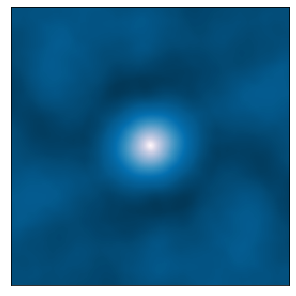

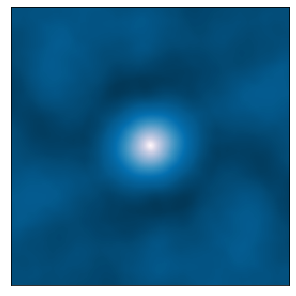

In [19]:
#Visualizing two-point statistics.

plot_microstructures(two_points_tr[1, :, :, 0], cmap='PuBu_r', 
                     colorbar=False, showticks=False)

In [20]:
#Printing some recrystallized volume fractions.

print('Recrystallized Volume Fraction 7 = ', two_points_tr[7, 130, 130, 0].compute())
print('Recrystallized Volume Fraction 1 = ', two_points_tr[1, 130, 130, 0].compute())
print('Recrystallized Volume Fraction 11 = ', two_points_tr[11, 130, 130, 0].compute())

Recrystallized Volume Fraction 7 =  0.6836611111111112
Recrystallized Volume Fraction 1 =  0.5172055555555556
Recrystallized Volume Fraction 11 =  0.7044305555555557


In [21]:
#Reshape the two-point statistics for PCA.

reshaped_two_points_tr = two_points_tr.reshape(24, -1)
reshaped_two_points_te = two_points_te.reshape(10, -1)
reshaped_two_points_tr.shape, reshaped_two_points_te.shape

((24, 136242), (10, 136242))

In [22]:
#PCA

pca = PCA(svd_solver='full', n_components=3)

pc_scores_tr = pca.fit_transform(reshaped_two_points_tr) #pc scores for training
pc_scores_te = pca.transform(reshaped_two_points_te) #pc scores for testing
pc_scores_tr.shape, pc_scores_te.shape

((24, 3), (10, 3))

In [23]:
print(pca.components_)
print(pca.components_.shape)

[[ 3.80253093e-03 -1.59638117e-05  3.80256226e-03 ... -1.59951370e-05
   3.80253093e-03 -1.59638117e-05]
 [ 1.00936875e-04 -3.90363816e-03  1.10943486e-04 ... -3.91364477e-03
   1.00936875e-04 -3.90363816e-03]
 [ 3.15849258e-03 -2.93950363e-03  3.22136603e-03 ... -3.00237708e-03
   3.15849258e-03 -2.93950363e-03]]
(3, 136242)


In [24]:
#Splitting the arrays for

pc1_tr, pc2_tr, pc3_tr = np.split(pc_scores_tr, 3, axis=1)
pc1_te, pc2_te, pc3_te = np.split(pc_scores_te, 3, axis=1)

print(pc1_tr.shape, pc1_te.shape)
print(pc2_te)

##Note: No "axis=1" in order to obtain pc-scores for different microstructure classes.

(24, 1) (10, 1)
[[ 17.48575331]
 [  8.37647973]
 [-14.60513319]
 [-10.82206027]
 [ 17.55667563]
 [ -7.83736325]
 [ 39.26734365]
 [-15.72641454]
 [ -2.9588256 ]
 [-10.48019383]]


In [25]:
zeros_tr=np.zeros((24, 2))
zeros_te=np.zeros((10, 2))

reshaped_pc1_tr=np.hstack((pc1_tr, zeros_tr))
reshaped_pc1_te=np.hstack((pc1_te, zeros_te))

print(reshaped_pc1_tr.shape, reshaped_pc1_te.shape)
print(reshaped_pc1_te)

(24, 3) (10, 3)
[[-89.15055373   0.           0.        ]
 [ 78.21496067   0.           0.        ]
 [ -6.77301829   0.           0.        ]
 [-59.9976976    0.           0.        ]
 [101.77028135   0.           0.        ]
 [ 27.58528698   0.           0.        ]
 [-94.02168252   0.           0.        ]
 [-37.3709383    0.           0.        ]
 [ 44.96159883   0.           0.        ]
 [ 16.84209892   0.           0.        ]]


In [26]:
#Explained variance by each principal component.

exp_var_pca=pca.explained_variance_ratio_*100
cum_sum=np.cumsum(pca.explained_variance_ratio_)*100
cum_sum_2d = [ '%.2f' % elem for elem in cum_sum ]
cum_sum_2d = np.array(cum_sum_2d)

print(exp_var_pca)

[9.60394448e+01 3.92543879e+00 1.20534502e-02]


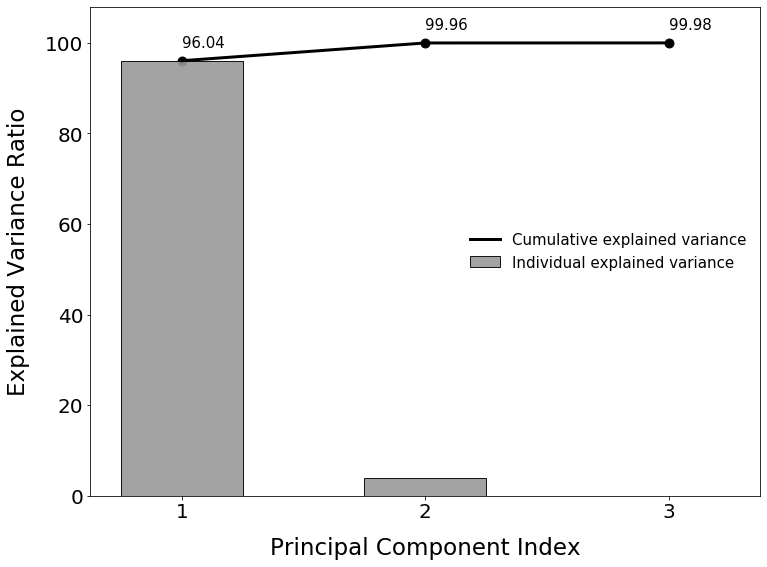

In [29]:
#Plotting the explained variance per pc.

plt.rcParams.update({'font.size': 15})

fig = plt.figure(1, figsize=(12, 9))

x1 = range(1, len(exp_var_pca)+1)
y1 = exp_var_pca
x2 = range(1, len(cum_sum)+1)
y2 = cum_sum

plt.bar(x1, y1, color='#999999', edgecolor='black', linewidth='1', alpha=0.9, width = 0.5, align='center', label='Individual explained variance')

plt.plot(x2, y2, label='Cumulative explained variance', c='black', linewidth=3)
plt.scatter(x2, y2, s=80, facecolors='black', edgecolors='black')

for i, txt in enumerate(cum_sum_2d):
    plt.annotate(txt, (x2[i], y2[i]), size=15, xytext=(x2[i], y2[i]+3))
    
plt.xlabel('Principal Component Index', fontsize=23, labelpad=15)
plt.ylabel('Explained Variance Ratio', fontsize=23, labelpad=15)

plt.xticks(np.arange(1, 4, step=1), fontsize=20)
plt.yticks(fontsize=20)

plt.legend(frameon=False, loc='best')
plt.ylim([0, 108])

#plt.savefig(plots_path + 'explained_variance.png', facecolor='w', dpi=600)
plt.show()

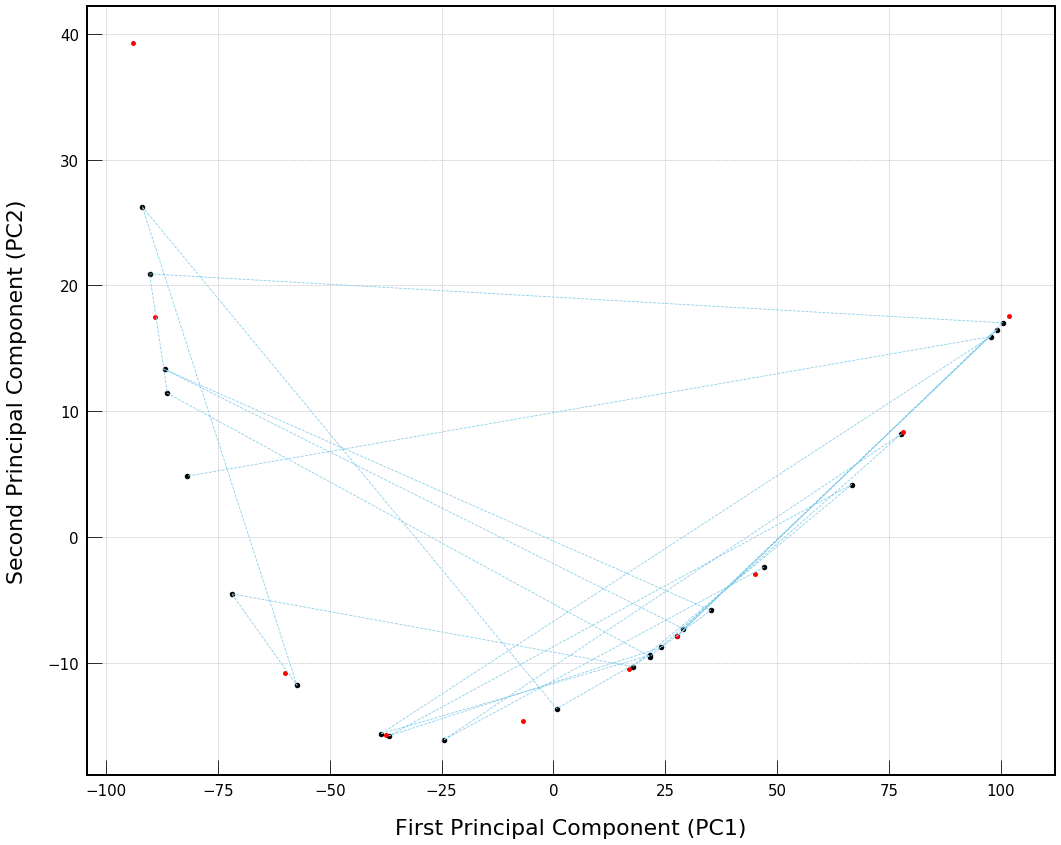

In [34]:
#Visualizing PCs.

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)

plt.scatter(pc_scores_tr[:,0], pc_scores_tr[:,1], c='black', marker='o', s=20, label='Y_train')
plt.plot(pc_scores_tr[:,0], pc_scores_tr[:,1], c='skyblue', ls='--', linewidth=0.8)

plt.scatter(pc_scores_te[:,0], pc_scores_te[:,1], c='red', marker='o', s=15, label='Y_test')

ax.set_xlabel("First Principal Component (PC1)",  fontsize=22, labelpad=20)
ax.set_ylabel("Second Principal Component (PC2)",  fontsize=22, labelpad=20)

ax.tick_params(axis="both", size=15, direction="in", pad=8)

ax.grid(which='major', axis='both', linestyle = '--', linewidth = 0.5)

ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('2') 

fig.tight_layout()

#fig.savefig(plots_path + 'principal_components.png', facecolor='w', dpi=600)
fig.show()

In [35]:
#Inverse-transforming the data.

two_points_inv_pc_tr = pca.inverse_transform(pc_scores_tr)
two_points_inv_pc1_tr = pca.inverse_transform(reshaped_pc1_tr)

two_points_inv_pc_te = pca.inverse_transform(pc_scores_te)
two_points_inv_pc1_te = pca.inverse_transform(reshaped_pc1_te)

In [36]:
#Reshaping the data.

recovered_two_points_pc_tr = np.reshape(two_points_inv_pc_tr, initial_shape_tr)
recovered_two_points_pc1_tr = np.reshape(two_points_inv_pc1_tr, initial_shape_tr)

recovered_two_points_pc_te = np.reshape(two_points_inv_pc_te, initial_shape_te)
recovered_two_points_pc1_te = np.reshape(two_points_inv_pc1_te, initial_shape_te)

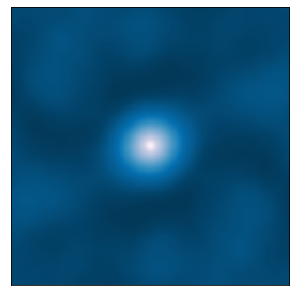

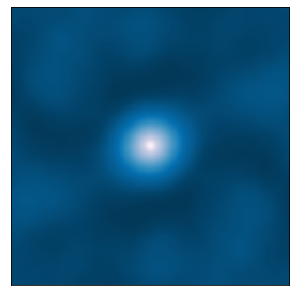

In [37]:
#Recovering two-point statistics using both PC scores.

plot_microstructures(recovered_two_points_pc_tr[1, :, :, 0], cmap='PuBu_r', 
                     colorbar=False, showticks=False)

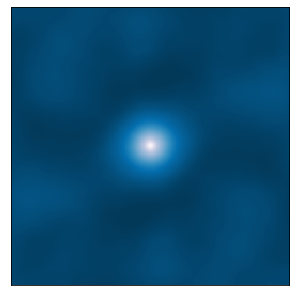

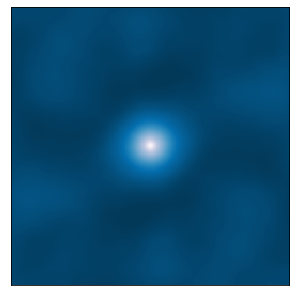

In [38]:
#Recovering two-point statistics using only PC1.
plot_microstructures(recovered_two_points_pc1_tr[1, :, :, 0], cmap='PuBu_r', 
                     colorbar=False, showticks=False)

In [41]:
#Loading GPR predictions.
gp_path = "./../../data/gp_predictions/"
#first surrogate
gp1_tr = genfromtxt(gp_path+'\GP1_tr.csv', delimiter=',')
gp1_te = genfromtxt(gp_path+'\GP1_te.csv', delimiter=',')
#second surrogate
gp2_tr = genfromtxt(gp_path+'\GP2_tr.csv', delimiter=',')
gp2_te = genfromtxt(gp_path+'\GP2_te.csv', delimiter=',')

#print(gp1_tr[:])

In [42]:
training_pred = np.stack([gp1_tr, gp2_tr, np.zeros(24)]).T
testing_pred = np.stack([gp1_te, gp2_te, np.zeros(10)]).T

In [43]:
two_points_training_gp = pca.inverse_transform(training_pred)
print(two_points_training_gp)

[[0.49508397 0.20898969 0.49507164 ... 0.20900201 0.49508397 0.20898969]
 [0.45395087 0.22062798 0.45390882 ... 0.22067003 0.45395087 0.22062798]
 [0.22114617 0.24900745 0.22103196 ... 0.24912166 0.22114617 0.24900745]
 ...
 [0.74080338 0.12087375 0.74101632 ... 0.12066081 0.74080338 0.12087375]
 [0.47054878 0.2147513  0.47052175 ... 0.21477832 0.47054878 0.2147513 ]
 [0.0337636  0.13620308 0.03393903 ... 0.13602765 0.0337636  0.13620308]]


In [44]:
two_points_testing_gp = pca.inverse_transform(testing_pred)
print(two_points_testing_gp)

[[0.49584442 0.21196434 0.49582447 ... 0.21198429 0.49584442 0.21196434]
 [0.00654623 0.05379221 0.00693298 ... 0.05340546 0.00654623 0.05379221]
 [0.20809927 0.24800811 0.20798766 ... 0.24811973 0.20809927 0.24800811]
 ...
 [0.26393099 0.23583859 0.26385043 ... 0.23591915 0.26393099 0.23583859]
 [0.29579107 0.20272381 0.29579531 ... 0.20271956 0.29579107 0.20272381]
 [0.75606335 0.12007152 0.75627831 ... 0.11985656 0.75606335 0.12007152]]


In [45]:
#Recovering two-point statistics from GPR predictions.

recovered_two_points_tr = np.reshape(two_points_training_gp, initial_shape_tr)
recovered_two_points_te = np.reshape(two_points_testing_gp, initial_shape_te)
print(recovered_two_points_te.shape)

(10, 261, 261, 2)


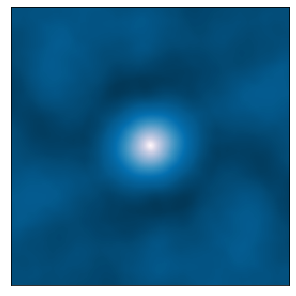

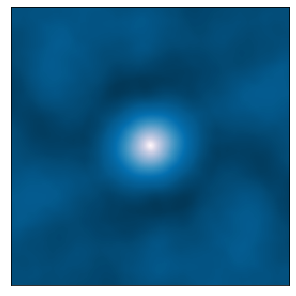

In [46]:
plot_microstructures(two_points_tr[1, :, :, 0], cmap='PuBu_r', 
                     colorbar=False,  showticks=False)

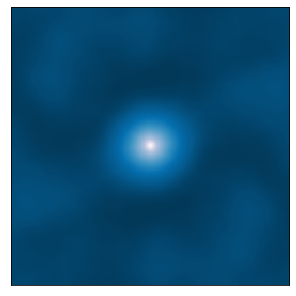

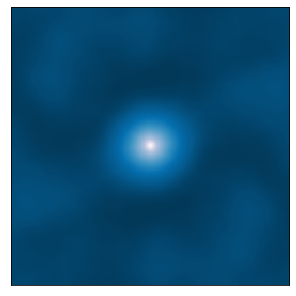

In [47]:
plot_microstructures(recovered_two_points_tr[1, :, :, 0], cmap='PuBu_r', 
                     colorbar=False, showticks=False)

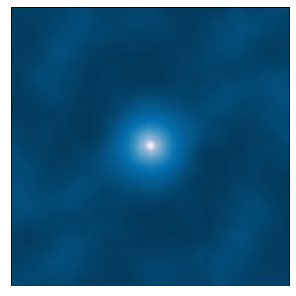

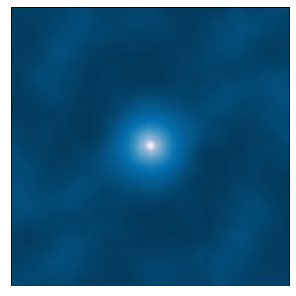

In [48]:
plot_microstructures(two_points_te[8, :, :, 0], cmap='PuBu_r', 
                     colorbar=False, showticks=False)

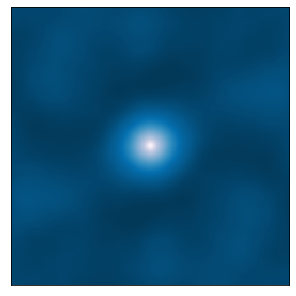

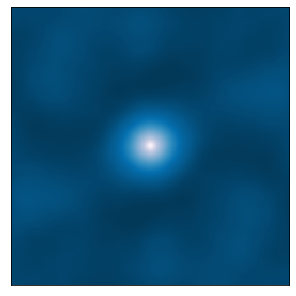

In [49]:
plot_microstructures(recovered_two_points_te[8, :, :, 0], cmap='PuBu_r', 
                     colorbar=False, showticks=False)